<a href="https://colab.research.google.com/github/debi92/Equalee/blob/main/Tuition_Fee_Prediction_tflite2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tuition Fee Prediction based on Student's Family's Socio-Economic Factors

Education is still a major problem in Indonesia. One of the main reason is the unequality of educational facility and socio economic factors that caused someone to dropout from school. This project is to give prediction on which category of tuition fee that every student need to pay based on their family's socio-economic factors, such as: income, electricity bill, water bill, internet bill, house ownership, house size, number of dependents in the family so it will give an equality in the payment of education fees, where people with better economies will help paying for the poorer education. 
Manually analyzing these factors is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning. In this notebook, we will build an automatic tuition fee predictor using machine learning techniques.

The dataset we used was made by ourselves by gaining data from parents in Java (mostly Jakarta and West Java). We asked them their socio economic background and the tuition fee their paying monthly. 
The structure of this notebook is as follows:

First, we will start off by loading and viewing the dataset.

1.   First, we will start by importing the library that needed in this project
2.   Then we will load and view the dataset. 
3.   We will see that the dataset has a mixture of both numerical and non-numerical features, that it contains values from different ranges.
4.   We will have to preprocess the dataset to ensure the machine learning model we choose can make good predictions.
5.   After our data is in good shape, we will do some exploratory data analysis to build our intuitions.
6.   Finally, we will build a machine learning model that can predict the tuition fee's category. 

# 1. Import Library & Load Data

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from pandas import Series, DataFrame

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

import seaborn as sb

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [2]:
#version of library & python
print('Python: ', sys.version)
print('Pandas: ', pd.__version__)
print('Numpy: ', np.__version__)
print('Matplotlib',matplotlib.__version__)
print('Seaborn:',sb.__version__)
print('Tensorflow:',tf.__version__)

Python:  3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Pandas:  1.1.5
Numpy:  1.19.5
Matplotlib 3.2.2
Seaborn: 0.11.1
Tensorflow: 2.5.0


In [4]:
tfp = pd.read_csv('/content/Dataset Sosial Ekonomi dan Uang Sekolah_new kat.csv')
tfp.head()

,Nama,Domisili,Pekerjaan,Tingkat,Nama sekolah,Jenis sekolah,Biaya sekolah,Kepemilikan rumah,Jenis bangunan,Ukuran rumah,Listrik,Air,Internet,Penghasilan,Jumlah tanggungan,Kategori final
0,HN,Jakarta,IRT,SD,Chandra Kusuma,Swasta,Rp 500.001 - Rp 1.000.000,Milik sendiri/ keluarga,Rumah,< 36 m2,Rp. 500.001 – Rp. 1.000.000,Rp. 250.001 – Rp. 500.000,Rp. 100.000 – Rp. 250.000,Rp. 3.000.001 - Rp. 6.000.000,2,2
1,HN,Jakarta,IRT,SD,SDN 01 pejagalan,Negri,≤ Rp. 100.000,Milik sendiri/ keluarga,Rumah,< 36 m2,Rp. 500.001 – Rp. 1.000.000,Rp. 250.001 – Rp. 500.000,Rp. 100.000 – Rp. 250.000,Rp. 3.000.001 - Rp. 6.000.000,2,2
2,SG,Banten,Guru,SD,SD 03,Negri,≤ Rp. 100.000,Kontrak/ sewa,Rumah,36 – 60 m2,Rp. 250.001 – Rp. 500.000,≤ Rp. 100.000,Rp. 100.000 – Rp. 250.000,Rp. 3.000.001 - Rp. 6.000.000,3,1
3,Ros,Jakarta,Wiraswasta,SD,SD CHANDRA KUSUMA,Swasta,Rp 500.001 - Rp 1.000.000,Kontrak/ sewa,Rumah,36 – 60 m2,Lebih dari Rp 1.000.000,Rp. 500.001 – Rp. 1.000.000,Rp. 250.001 – Rp. 500.000,Rp. 10.000.001 - Rp.20.000.000,1,2
4,DS,Jakarta,IRT,SD,Chandra Kusuma,Swasta,Rp 500.001 - Rp 1.000.000,Milik sendiri/ keluarga,Rumah,61 – 90 m2,Lebih dari Rp 1.000.000,Rp. 100.000 – Rp. 250.000,Rp. 100.000 – Rp. 250.000,Rp. 10.000.001 - Rp.20.000.000,3,2


# 2. Check Data Type

In [5]:
tfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Nama               113 non-null    object
 1   Domisili           113 non-null    object
 2   Pekerjaan          113 non-null    object
 3   Tingkat            113 non-null    object
 4   Nama sekolah       113 non-null    object
 5   Jenis sekolah      113 non-null    object
 6   Biaya sekolah      113 non-null    object
 7   Kepemilikan rumah  113 non-null    object
 8   Jenis bangunan     113 non-null    object
 9   Ukuran rumah       113 non-null    object
 10  Listrik            113 non-null    object
 11  Air                113 non-null    object
 12  Internet           113 non-null    object
 13  Penghasilan        113 non-null    object
 14  Jumlah tanggungan  113 non-null    object
 15  Kategori final     113 non-null    int64 
dtypes: int64(1), object(15)
memory usage: 14.2+ 

In [6]:
tfp.describe()

,Kategori final
count,113.000000
mean,1.893805
std,0.659584
min,0.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,4.000000


## 3. Change categorical data

In [7]:
biaya_dict = {'≤ Rp. 100.000':0,'Rp 100.001 - Rp 500.000':1,'Rp 500.001 - Rp 1.000.000':2,'Rp 1.000.001 - Rp 2.000.000':3,'lebih dari 2 juta':4}
tfp['Biaya kat'] = tfp['Biaya sekolah'].map(biaya_dict)

kepemilikan_dict = {'Milik sendiri/ keluarga':2,'Kontrak/ sewa':1}
tfp['Kepemilikan kat'] = tfp['Kepemilikan rumah'].map(kepemilikan_dict)

jenis_bangunan_dict = {'Rumah susun':1,'Apartemen':2,'Rumah':3,'Ruko':4}
tfp['Jenis bangunan kat'] = tfp['Jenis bangunan'].map(jenis_bangunan_dict)

ukuran_rumah_dict = {'< 36 m2':1,'36 – 60 m2':2,'61 – 90 m2':3,'91 – 120 m2':4, '121 – 150 m2':5, 'lebih dari 150 m2':6}
tfp['Ukuran rumah kat'] = tfp['Ukuran rumah'].map(ukuran_rumah_dict)

utility_dict = {'≤ Rp. 100.000':1,'Rp. 100.000 – Rp. 250.000':2,'Rp. 250.001 – Rp. 500.000':3,'Rp. 500.001 – Rp. 1.000.000':4, 'Lebih dari Rp 1.000.000':5}
tfp['Listrik kat'] = tfp['Listrik'].map(utility_dict)
tfp['Air kat'] = tfp['Air'].map(utility_dict)
tfp['Internet kat'] = tfp['Internet'].map(utility_dict)

penghasilan_dict = {'≤ Rp. 3.000.000':1,'Rp. 3.000.001 - Rp. 6.000.000':2,'Rp. 6.000.001 - Rp. 10.000.000':3,'Rp. 10.000.001 - Rp.20.000.000':4,'Lebih dari Rp.20.000.000':5}
tfp['Penghasilan kat'] = tfp['Penghasilan'].map(penghasilan_dict)

tanggungan_dict = {'lebih dari 4':1,'4':2,'3':3,'2':4,'1':5}
tfp['Tanggungan kat'] = tfp['Jumlah tanggungan'].map(tanggungan_dict)

tfp.head()

,Nama,Domisili,Pekerjaan,Tingkat,Nama sekolah,Jenis sekolah,Biaya sekolah,Kepemilikan rumah,Jenis bangunan,Ukuran rumah,Listrik,Air,Internet,Penghasilan,Jumlah tanggungan,Kategori final,Biaya kat,Kepemilikan kat,Jenis bangunan kat,Ukuran rumah kat,Listrik kat,Air kat,Internet kat,Penghasilan kat,Tanggungan kat
0,HN,Jakarta,IRT,SD,Chandra Kusuma,Swasta,Rp 500.001 - Rp 1.000.000,Milik sendiri/ keluarga,Rumah,< 36 m2,Rp. 500.001 – Rp. 1.000.000,Rp. 250.001 – Rp. 500.000,Rp. 100.000 – Rp. 250.000,Rp. 3.000.001 - Rp. 6.000.000,2,2,2,2,3,1,4,3,2,2,4
1,HN,Jakarta,IRT,SD,SDN 01 pejagalan,Negri,≤ Rp. 100.000,Milik sendiri/ keluarga,Rumah,< 36 m2,Rp. 500.001 – Rp. 1.000.000,Rp. 250.001 – Rp. 500.000,Rp. 100.000 – Rp. 250.000,Rp. 3.000.001 - Rp. 6.000.000,2,2,0,2,3,1,4,3,2,2,4
2,SG,Banten,Guru,SD,SD 03,Negri,≤ Rp. 100.000,Kontrak/ sewa,Rumah,36 – 60 m2,Rp. 250.001 – Rp. 500.000,≤ Rp. 100.000,Rp. 100.000 – Rp. 250.000,Rp. 3.000.001 - Rp. 6.000.000,3,1,0,1,3,2,3,1,2,2,3
3,Ros,Jakarta,Wiraswasta,SD,SD CHANDRA KUSUMA,Swasta,Rp 500.001 - Rp 1.000.000,Kontrak/ sewa,Rumah,36 – 60 m2,Lebih dari Rp 1.000.000,Rp. 500.001 – Rp. 1.000.000,Rp. 250.001 – Rp. 500.000,Rp. 10.000.001 - Rp.20.000.000,1,2,2,1,3,2,5,4,3,4,5
4,DS,Jakarta,IRT,SD,Chandra Kusuma,Swasta,Rp 500.001 - Rp 1.000.000,Milik sendiri/ keluarga,Rumah,61 – 90 m2,Lebih dari Rp 1.000.000,Rp. 100.000 – Rp. 250.000,Rp. 100.000 – Rp. 250.000,Rp. 10.000.001 - Rp.20.000.000,3,2,2,2,3,3,5,2,2,4,3


In [8]:
tfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Nama                113 non-null    object
 1   Domisili            113 non-null    object
 2   Pekerjaan           113 non-null    object
 3   Tingkat             113 non-null    object
 4   Nama sekolah        113 non-null    object
 5   Jenis sekolah       113 non-null    object
 6   Biaya sekolah       113 non-null    object
 7   Kepemilikan rumah   113 non-null    object
 8   Jenis bangunan      113 non-null    object
 9   Ukuran rumah        113 non-null    object
 10  Listrik             113 non-null    object
 11  Air                 113 non-null    object
 12  Internet            113 non-null    object
 13  Penghasilan         113 non-null    object
 14  Jumlah tanggungan   113 non-null    object
 15  Kategori final      113 non-null    int64 
 16  Biaya kat           113 no

In [9]:
tfp.describe()

,Kategori final,Biaya kat,Kepemilikan kat,Jenis bangunan kat,Ukuran rumah kat,Listrik kat,Air kat,Internet kat,Penghasilan kat,Tanggungan kat
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,1.893805,2.000000,1.876106,2.955752,3.300885,3.858407,2.539823,2.893805,3.371681,2.734513
std,0.659584,1.217433,0.330928,0.409472,1.540437,1.179189,1.060958,0.890052,1.317429,1.093958
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,2.000000,3.000000,3.000000,4.000000,2.000000,3.000000,3.000000,3.000000
75%,2.000000,3.000000,2.000000,3.000000,4.000000,5.000000,3.000000,3.000000,5.000000,3.000000
max,4.000000,4.000000,2.000000,4.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000


# 4. Preprocessing Data

In [10]:
cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16]
tfp.drop(tfp.columns[cols],axis=1,inplace=True)

tfp.head()


,Kategori final,Kepemilikan kat,Jenis bangunan kat,Ukuran rumah kat,Listrik kat,Air kat,Internet kat,Penghasilan kat,Tanggungan kat
0,2,2,3,1,4,3,2,2,4
1,2,2,3,1,4,3,2,2,4
2,1,1,3,2,3,1,2,2,3
3,2,1,3,2,5,4,3,4,5
4,2,2,3,3,5,2,2,4,3


## 5. Visualize Data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

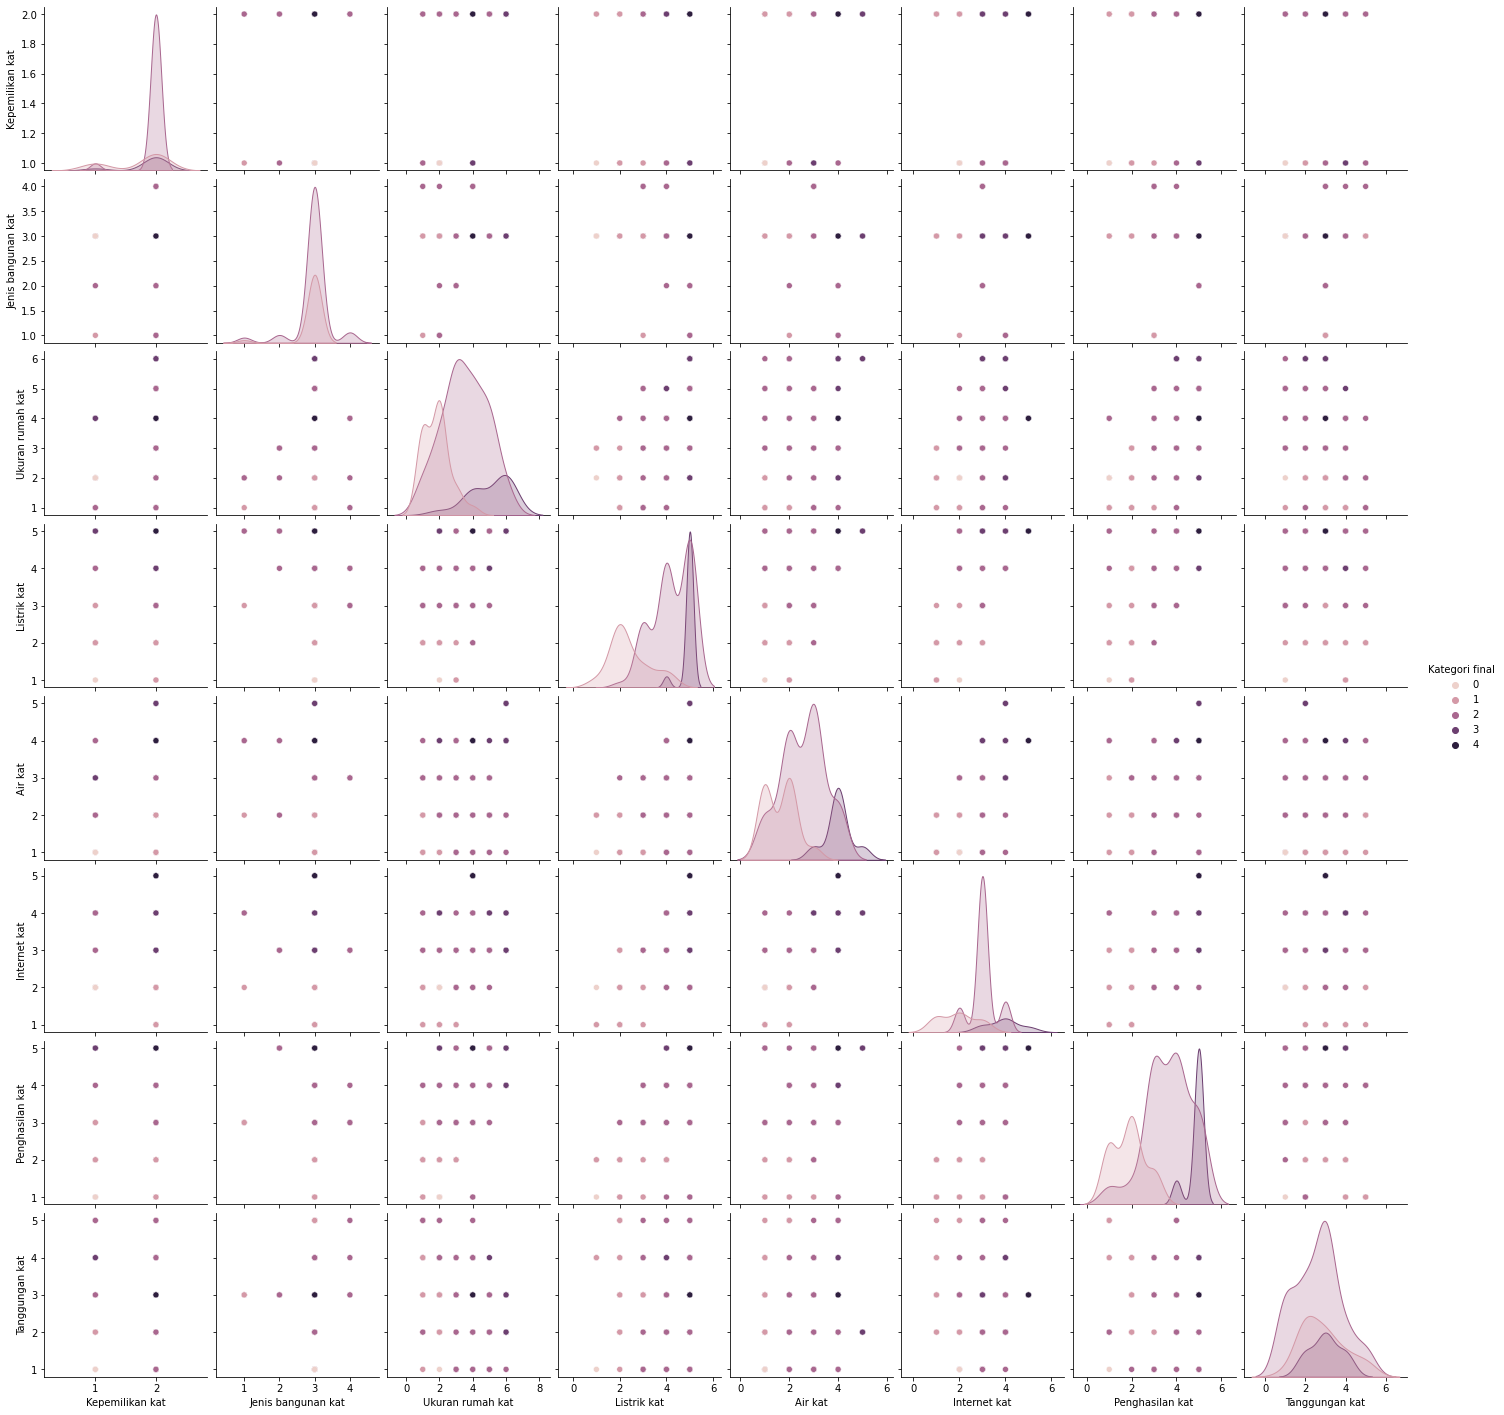

In [11]:
import seaborn as sns
sns.pairplot(tfp,hue='Kategori final')
plt.show()

# 6. Split the Data

In [13]:
# Segregate features and labels into separate variables
y = tfp['Kategori final']
X = tfp.drop(['Kategori final'], axis=1)

scaler = StandardScaler()

X = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.2,
                                random_state=42)

In [14]:
X_test.shape


(23, 8)

# 7. Modeling and Training

In [15]:
models = {
    'log_reg':LogisticRegression(random_state=42),
    
    'svm':SVC(random_state=42),
    
    'dtree':DecisionTreeClassifier(random_state=42),
    
    'rforest':RandomForestClassifier(random_state=42)
}

In [16]:
for m in models.keys():
    print(m)
    scores = cross_val_score(models[m],
                             X_train, y_train, 
                             scoring='accuracy',
                             cv=5)
    
    print(f'Mean accuracy {scores.mean()} \n')
    print(40*'*','\n')

log_reg
Mean accuracy 0.9111111111111111 

**************************************** 

svm
Mean accuracy 0.9333333333333332 

**************************************** 

dtree
Mean accuracy 0.8222222222222222 

**************************************** 

rforest


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Mean accuracy 0.9111111111111111 

**************************************** 



In [17]:
inputs = tf.keras.Input(shape=(8,))
x = tf.keras.layers.Dense(32, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

epochs = 20

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
)

Epoch 1/20
3/3 [==============================] - 1s 105ms/step - loss: 1.5555 - accuracy: 0.5556 - val_loss: 1.4899 - val_accuracy: 0.5556
Epoch 2/20
3/3 [==============================] - 0s 13ms/step - loss: 1.4132 - accuracy: 0.5833 - val_loss: 1.3725 - val_accuracy: 0.5556
Epoch 3/20
3/3 [==============================] - 0s 14ms/step - loss: 1.2855 - accuracy: 0.5972 - val_loss: 1.2684 - val_accuracy: 0.5556
Epoch 4/20
3/3 [==============================] - 0s 12ms/step - loss: 1.1680 - accuracy: 0.6528 - val_loss: 1.1701 - val_accuracy: 0.5556
Epoch 5/20
3/3 [==============================] - 0s 12ms/step - loss: 1.0661 - accuracy: 0.6806 - val_loss: 1.0772 - val_accuracy: 0.6111
Epoch 6/20
3/3 [==============================] - 0s 12ms/step - loss: 0.9663 - accuracy: 0.6944 - val_loss: 0.9910 - val_accuracy: 0.6667
Epoch 7/20
3/3 [==============================] - 0s 12ms/step - loss: 0.8795 - accuracy: 0.7500 - val_loss: 0.9148 - val_accuracy: 0.6667
Epoch 8/20
3/3 [==========

# 8. Summary & Result


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 11,365
Trainable params: 11,365
Non-trainable params: 0
_________________________________________________________________


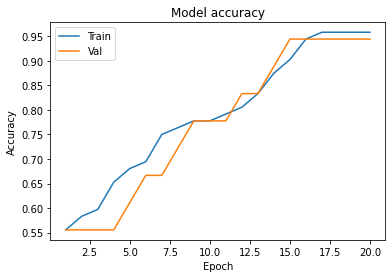

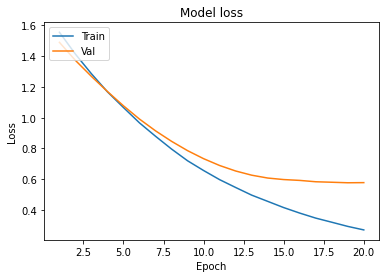

In [19]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history, epochs)


In [20]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.2788 - accuracy: 0.9130


[0.2787565290927887, 0.9130434989929199]

# 9. Prediction Example

In [21]:
# define input
new_input = [[2,4,6,5,5,5,5,5]]
new_output = model.predict(new_input)
print(new_output)

[[1.8420305e-11 3.7860210e-12 1.7109687e-02 9.8289031e-01 2.6036404e-12]]


##10. Save Model & Convert

In [23]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/1/assets


In [24]:
#Convert Saved model to TFLite
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

47576

In [25]:
#Initialize TFLite Interpreter
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [26]:
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
inputs, outputs = [], []
for _ in range(100):
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    interpreter.invoke()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
    
    # Test the TensorFlow model on random input data.
    tf_results = model(tf.constant(input_data))
    output_data = np.array(tf_results)
    
    inputs.append(input_data[0][0])
    outputs.append(output_data[0][0])

In [27]:
#download TFLite Model
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>